# 분류 2

## XGBoost(eXtra Gradient Boost)

- 트리 기반 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나
- GBM에 기반하고 있지만, GBM의 느린 수행 시간 및 과적합 규제(Regularization) 부재 등의 문제를 해결함
    - 랜덤 포레스트에 비해 빠르다는 의미는 아님
    - 자체에 과적합 규제 기능이 있어서 좀 더 강건한 모델을 만들 수 있음 -> Robustness
    - 자체 내장된 교차 검증
    - 결손값 자체 처리
    
- 파이썬 래퍼 XGBoost 모듈, 사이킷런 래퍼 XGBoost 모듈

### 파이썬 래퍼 XGBoost 하이퍼 파라미터

- GBM과 유사한 하이퍼 파라미터를 가지고 있음.
    - + early stopping, 과적합 규제 하이퍼 파라미터 등이 추가됨
- 사이킷런 래퍼 모듈과 일부 하이퍼 파라미터가 약간 다름

1. 일반 파라미터 : 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로, 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
2. 부스트 파라미터 : 트리 최적화, 부스팅, regularization 등과 관련 파라미터
- 대부분의 파라미터가 속함
3. 학습 태스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터



#### 일반 파라미터
- `booster` : gbtree 혹은 gblinear 선택. default=gbtree
- `silent` : default=0, 출력 메시지를 나타내고 싶지 않을 경우 1로 설정
- `nthread` : CPU의 실행 스레드 개수를 조정, 디폴트는 CPU의 전체 스레드를 다 사용하는 것
    - 멀티 코어 CPU 시스템에서 일부만 사용하고 싶을 때 변경함

#### 부스터 파라미터
- ` eta` : default=0.3, alias:learning_rate
    - GBM의 learning rate와 같은 파라미터
    - 사이킷런 래퍼 클래스를 이용할 경우 learning_rate 파라미터로 대체됨
- `num_boost_rounds` : == n_estimator
- `min_child_weight` : default=1. 과적합 조정을 위해 사용. min_child_leaf와 유사
- `gamma` : default=0, alias: min_split_loss
     - 값이 클수록 과적합 감소 효과가 있음
     - 트리의 노드에서 추가 파티션을 만들기 위해 필요한 최소 손실 감소. 크면 클수록 더 보수적인 알고리즘이 생성된다
- `max_depth` : 트리 기반 알고리즘의 max_depth와 같음. default=6
- `sub_sample` : GBM의 sumsample과 동일함. 데이터 샘플링하는 비율을 지정
    - 0.5 -> 전체 데이터의 절반을 트리를 생성하는 데 사용
- `colsample_bytree` : GBM의 max_features와 유사
- `lambda` : default=1, L2 Regularization 적용 값. 값이 클수록 과적합 감소 효과
- `alpha` : default=0, L1 Regularization 적용 값. 값이 클수록 과적합 감소 효과
- `scale_pos_weight` : imbalanced 데이터의 균형을 유지하기 위한 파라미터


#### 학습 태스크 파라미터
- `objective` : 최솟값을 가져야할 손실 함수 정의. 이진 분류/다중 분류에 따라 달라짐
    - binary -> logistic
    - multi -> softmax
- `eval_metric` : 검증에 사용되는 함수. default)회귀인 경우 rmse, 분류인 경우 error

#### 과적합이 심할 경우
- eta 값을 낮춤, num_round(n_estimator) 늘림
- max_depth 낮춤
- min_child_weight 높임
- gamma 높임
- ...

#### early stopping

XGBoost는 수행 속도를 향상시키기 위한 대표적인 기능으로 Early Stopping 기능이 있음.
- n_estimators에 지정한 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 더 이상 개선되지 않으면 반복을 끝까지 수행하지 않고 중지함 -> 수행 시간 단축
- 예 : n_estimators=200, early stopping 파라미터=50
   -  1~200회까지 부스팅을 반복하다가 50회를 반복하는 동안 학습 오류가 감소하지 않으면 더 이상 부스팅을 진행하지 않고 종료함

In [1]:
import xgboost
print(xgboost.__version__)

1.3.0


### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

자체적으로 교차 검증, 성능 평가, 피처 importances 시각화 기능을 가지고 있음.

In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

In [3]:
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size=0.2, random_state=156)

In [7]:
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


파이썬 래퍼 XGBoost는 학습용과 테스트용 데이터 세트틀 위해 별도의 객체인 `DMatrix`를 생성함.
- 넘파이 입력 파라미터를 받아서 만들어지는 전용 데이터 셋임
- 주요 입력 파라미터 : `data`, `label`

In [8]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [9]:
dtrain

In [10]:
# XGBoost의 하이퍼 파라미터는 주로 딕셔너리 형태로 입력
params = { 'max_depth':3,
         'eta':0.1,
         'objective':'binary:logistic',
         'eval_metric':'logloss',
         'early_stopping':100}
# 조기 중단을 위해서는 eval_set과 eval_metric이 반드시 존재해야 함
# XGBoost는 반복마다 eval_set으로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류를 측정함
num_rounds=400

In [11]:
# 위 하이퍼 파라미터를 `train()` 에 전달
wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params= params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[16:50:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { early_stopping } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0

In [15]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

predict() 수행 결과값 10개만 표시, 예측 확률값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]


In [16]:
preds = [1 if x>0.5 else 0 for x in pred_probs]
print(f'예측값 10개만 표시: {preds[:10]}')

예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


`plot_importance()` : 피처의 중요도를 막대 그래프로 나타냄
- 기본 평가 지표로 f1 스코어를 기반으로 해 각 피처의 중요도를 나타냄

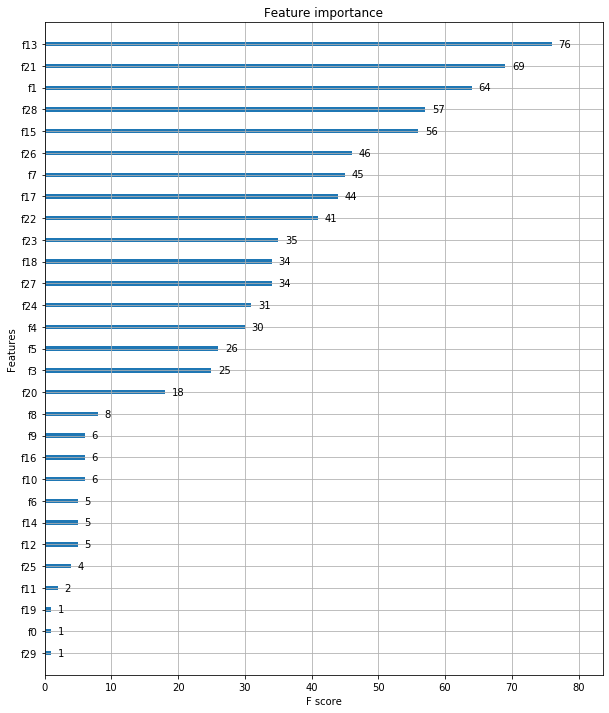

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

교차 검증(CV) API도 제공함. 

### 사이킷런 래퍼 XGBoost의 개요 및 적용

- 분류를 위한 `XGBClassifier`, 회귀를 위한 `XGBRegreessor`
- 파이썬 래퍼 모듈과 다른 하이퍼 파라미터
    - eta -> `learning_rate`
    - sub_sample -> `subsample`
    - lambda -> `reg_lambda`
    - alpha -> `reg_alpha`

In [18]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)

[16:56:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:56:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, y_pred):
  confusion = confusion_matrix(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  F1 = f1_score(y_test, y_pred)
  AUC = roc_auc_score(y_test, y_pred)
  # 평가지표 출력
  print('오차행렬:\n', confusion)
  print('\n정확도: {:.4f}'.format(accuracy))
  print('정밀도: {:.4f}'.format(precision))
  print('재현율: {:.4f}'.format(recall))
  print('F1: {:.4f}'.format(F1))
  print('AUC: {:.4f}'.format(AUC))


In [30]:
get_clf_eval(y_test, w_preds)

오차행렬:
 [[34  3]
 [ 2 75]]

정확도: 0.9561
정밀도: 0.9615
재현율: 0.9740
F1: 0.9677
AUC: 0.9465


조기중단 가능 -> `fit()` 에 파라미터를 입력하면 됨


In [31]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate = 0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
               eval_set = evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

[17:07:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	val

In [32]:
get_clf_eval(y_test, ws100_preds)

오차행렬:
 [[34  3]
 [ 2 75]]

정확도: 0.9561
정밀도: 0.9615
재현율: 0.9740
F1: 0.9677
AUC: 0.9465


조기 중단값을 너무 작게 하면 성능 저하를 불러일으킬 수 있음

In [33]:
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
get_clf_eval(y_test, ws10_preds)
# 저는 똑같이 나왔네요;

[17:08:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	val

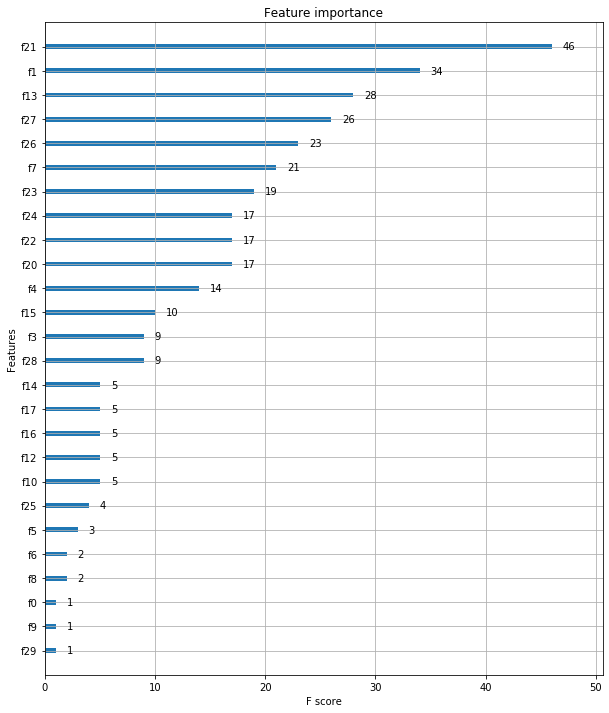

In [34]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)

## LightGBM

XGBoost에서 GridSearchCV로 하이퍼 파라미터를 튜닝하다보면 수행 시간이 오래 걸려서 많은 파라미터를 튜닝하기에 어려움을 겪을 수밖에 없음


`LightGBM`은 예측 성능도 별 차이가 없고, 학습 시간이 상대적으로 빠름.
- But, **적은 데이터 셋에 쓴다면 과적합이 발생하기 쉬움**
    - 10000 건 이하의 데이터 세트 정도


LightGBM은 **리프 중심 트리 분할** 방식을 사용함
- 기존의 대부분 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level Wise) 방식을 사용함.
    - 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이가 최소화될 수 있음
    - 오버 피팅에 강한 구조를 가질 수 있기 때문에 이렇게 만듦. But, 균형을 맞추기 위한 시간이 오래 걸림
- LightGBM의 리프 중심 트리 분할 방식은, 트리 균형을 맞추지 않고 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 길어지고 비대칭적인 규칙 트리가 생성됨
    - 이렇게 최대 손실값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습ㅇ르 반복할수록 결국 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있다는 것이 LightGBM의 구현 사상임


### LightGBM의 장점(vs. XGBoost)
- 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할(one-hot encoding을 사용하지 않고도 카테고리형 피쳐를 최적으로 변환하고 이에 따른 노드 분할 수행)


### LightGBM 하이퍼 파라미터

#### 주요 파라미터

- `num_iterations` : default=100, 반복 수행하려는 트리의 개수 지정. 너무 크면 과적합
- `learning_rate` : default=0.1
- `max_depth` : default=1, 0보다 작은 값을 지정하면 깊이 제한 X. LightGBM은 깊이가 다른 GBM 알고리즘보다 상대적으로 더 깊음
- `min_data_in_leaf` : default=20, 리프 노드가 되기 위해 최소한 필요한 레코드 수
- `min_leaves` : default=31, 하나의 트리가 가질 수 있는 최대 리프 개수
- `boosting` : default=gbdt, 부스팅 트리를 생성하는 알고리즘
    - gbdt : 일반적인 GBM
    - rf : Random Forest
- `bagging_fraction` : default=1.0, 트리가 커져서 과적합 되는 것을 제어하기 위해서 데이터를 샘플링하는 비율을 지정함
- `feature_fraction` : 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율
- `lambda_l2` : L2 Regularization 제어를 위한 값
- `lambda_l1` : L1 Redularization 제어를 위한 값


#### Learning Task 파라미터
- `objective` : 손실 함수 정의

### 하이퍼 파라미터 튜닝 방안
- num_leaves 개수를 중심으로 `min_child_samples(min_data_in_leaf), max_depth` 를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안
    - `num_leaves` 는 개별 트리가 가질 수 있는 최대 리프의 개수
    - LightGBM 모델의 복잡도를 제어하는 주요 파라미터
    - 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 너무 큰 값으로 하면 과적합 가능성 증가
- min_data_in_leaf(sklearn: min_child_samples) -> 트리가 깊어지는 것을 방지함
- max_depth : 명시적으로 깊이의 크기를 제한. 과적합 개선


- lr을 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋음. (n_estimators가 너무 크면 과적합 가능성)
- 이 외에도 regularization 적용하거나, ...


### LightGBM 적용 - 위스콘신 유방암 예측

In [35]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

In [36]:
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)
lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

In [37]:
get_clf_eval(y_test, preds)

오차행렬:
 [[33  4]
 [ 1 76]]

정확도: 0.9561
정밀도: 0.9500
재현율: 0.9870
F1: 0.9682
AUC: 0.9395


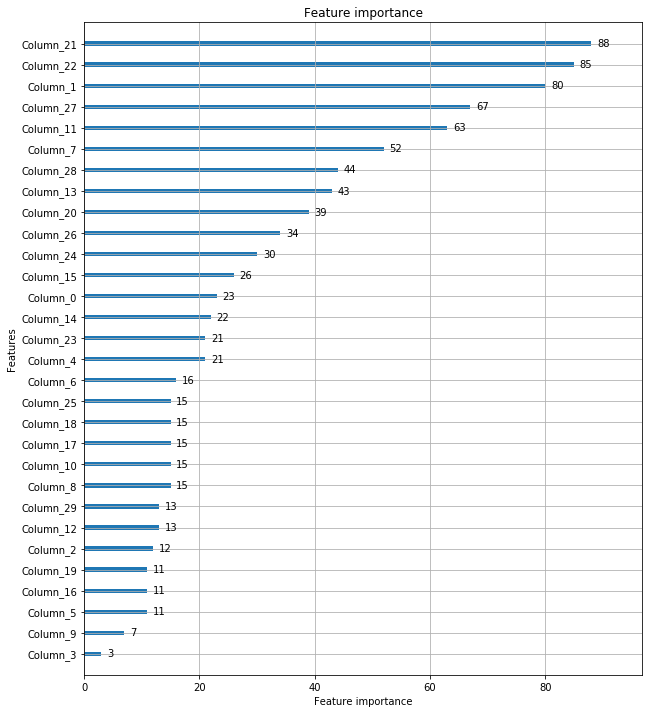

In [38]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

### 분류 실습 - 캐글 산탄데르 고객 만족 예측

#### 데이터 전처리

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('../data/train_santander.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head()

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [40]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [41]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [43]:
cust_df.describe()
# var3 컬럼에 min값 	-999999.000000	 -> NaN이나 특정 예외 값을 이렇게 처리했을 것 -> replace 필요

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [44]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis = 1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape: {0}, 테스트 세트 shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 shape: (60816, 369), 테스트 세트 shape: (15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


#### XGBoost 모델 학습과 하이퍼 파라미터 튜닝


In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)]) # 실제에서는 eval 데이터에 test 데이터를 넣으면 안됨!
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85830	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88072	validation_1-auc:0.84117
[16]	validation_0-auc:0.88237	validation_1-auc:0.84101
[17]	validation_0-auc:0.88352	validation_1-auc:0.84071
[18]	validation_0-au

칼럼의 개수가 많으므로 과적합 가능성이 있음
- max_depth, min_child_weight, colsamply_bytree 하이퍼 파라미터만 일차 튜닝 대상으로 함


**학습 시간이 많이 필요한 ML 모델인 경우, 하이퍼 파라미터 튜닝을 수행하는 요령 중 첫 번째는 먼저 2\~3개 정도의 파라미터를 결합해 최적 파라미터를 찾아낸 뒤에 이 최적 파라미털르 기반으로 다시 1~2개 파라미터를 결합해 파라미터 튜닝을 수행하는 것임**


In [47]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100)

params= {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

In [48]:
gridcv = GridSearchCV(xgb_clf, param_grid=params)

In [49]:
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
          eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-auc:0.72255	validation_1-auc:0.72640
[1]	validation_0-auc:0.74625	validation_1-auc:0.75051
[2]	validation_0-auc:0.81675	validation_1-auc:0.81906
[3]	validation_0-auc:0.82734	validation_1-auc:0.82620
[4]	validation_0-auc:0.83559	validation_1-auc:0.83410
[5]	validation_0-auc:0.83854	validation_1-auc:0.83449
[6]	validation_0-auc:0.83653	validation_1-auc:0.83319
[7]	validation_0-auc:0.84281	validation_1-auc:0.83717
[8]	validation_0-auc:0.84240	validation_1-auc:0.83435
[9]	validation_0-auc:0.84139	validation_1-auc:0.83315
[10]	validation_0-auc:0.84795	validation_1-auc:0.83874
[11]	validation_0-auc:0.85114	validation_1-auc:0.84039
[12]	validation_0-auc:0.85300	validation_1-auc:0.84080
[13]	validation_0-auc:0.85371	validation_1-auc:0.84205
[14]	validation_0-auc:0.85534	validation_1-auc:0.84046
[15]	validation_0-auc:0.85838	validation_1-auc:0.84232
[16]	validation_0-auc:0.85907	validation_1-auc:0.84237
[17]	validation_0-auc:0.86128	validation_1-auc:0.84349
[18]	validation_0-au

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [50]:
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1}


In [51]:
xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8432


In [52]:
xgb_clf = XGBClassifier(n_estimator=1000, random_state=156, leanring_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc", eval_set=[(X_train,y_train), (X_test, y_test)])

[18:48:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { leanring_rate, n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74129	validation_1-auc:0.74595
[1]	validation_0-auc:0.81384	validation_1-auc:0.81779
[2]	validation_0-auc:0.83376	validation_1-auc:0.82990
[3]	validation_0-auc:0.83738	validation_1-auc:0.83207
[4]	validation_0-auc:0.84044	validation_1-auc:0.83269
[5]	validation_0-auc:0.84322	validation_1-auc:0.83314
[6]	validation_0-auc:0.84674	validation_1-auc:0.83516
[7]	validation_0-auc:0.84628	validation_1-auc:0.83592
[8]	validation_0-auc:0.85009	validation_1-auc:0.83742
[9]	validation_0-auc:0.85295	validation_1-auc:0.84198
[10]	validation_0-auc:0.85493	validation_1-auc:0.84202


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              leanring_rate=0.02, learning_rate=0.300000012, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=1000, n_estimators=100,
              n_jobs=12, num_parallel_tree=1, random_state=156, reg_alpha=0.03,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8447


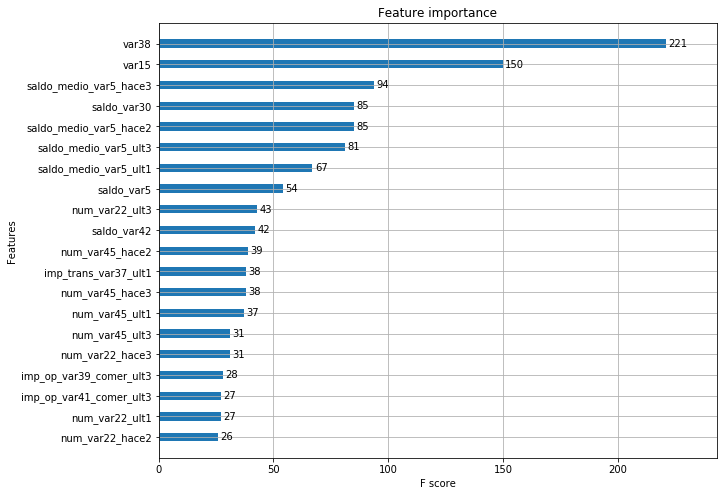

In [54]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [56]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_loglos

In [57]:
from sklearn.model_selection import GridSearchCV

LGBM_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32, 64],
         'max_depth':[128, 160],
         'min_child_samples':[60,100],
         'subsample':[0.8,1]}

In [58]:
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
          eval_set=[(X_train, y_train), (X_test, y_test)])

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	val

GridSearchCV(estimator=LGBMClassifier(n_estimators=500),
             param_grid={'max_depth': [128, 160],
                         'min_child_samples': [60, 100], 'num_leaves': [32, 64],
                         'subsample': [0.8, 1]})

In [60]:
print('GridSearchCV 최적 하이퍼 파라미터:', gridcv.best_params_)

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 128, 'min_child_samples': 60, 'num_leaves': 32, 'subsample': 0.8}


In [61]:
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

ROC AUC: 0.8418


In [62]:
gridcv.predict_proba(X_test)[:,1][:10]

array([0.00391056, 0.01719934, 0.01107997, 0.01357463, 0.02718107,
       0.00404132, 0.00359242, 0.00760926, 0.01779133, 0.06693998])

In [63]:
gridcv.predict_proba(X_test)[:][:10]

array([[0.99608944, 0.00391056],
       [0.98280066, 0.01719934],
       [0.98892003, 0.01107997],
       [0.98642537, 0.01357463],
       [0.97281893, 0.02718107],
       [0.99595868, 0.00404132],
       [0.99640758, 0.00359242],
       [0.99239074, 0.00760926],
       [0.98220867, 0.01779133],
       [0.93306002, 0.06693998]])

In [64]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
            verbose=True)


[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.1

LGBMClassifier(max_depth=128, min_child_samples=100, n_estimators=1000,
               num_leaves=32, subsample=0.8)

In [65]:
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

ROC AUC: 0.8417


## 분류 실습 - 캐글 신용카드 사기 검출

### 언더 샘플링과 오버 샘플링의 이해
이상 탐지의 경우,
**이상 레이블을 가지는 데이터 건수는 매우 적기 때문에** 제대로 다양한 유형을 학습시키지 못하는 반면에, 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉬움.


-> 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요함.
- 대표적으로 `Oversampling`, `Undersampling`
- 오버 샘플링 방식이 예측 성능상 유리한 경우가 많아 주로 사용됨




1. 언더 샘플링
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
- 정상 레이블 데이터를 10,000 -> 100건으로 줄이는 방식
- 너무 많은 정상 레이블을 감소시키기 때문에, 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있음


2. 오버 샘플링
- 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
- 동일한 데이터를 단순히 증식시키는 방법은 Overfitting이 되기 때문에 의미가 없으므로, 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식함
- `SMOTE(Synthetic Minority Over-sampling technique)`
    - 적은 데이터 세트에 있는 개별 데이터들의 K-Nearest-Neighbor을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값들로 만들어서 기존 데이터와 약간 차이가 있는 새로운 데이터를 생성하는 방식
    

### 데이터 일차 가공 및 모델 학습/예측/평가

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('../data/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [70]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [71]:
# preprocess 후 train/test 데이터 셋 반환
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [72]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)

print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [73]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

get_clf_eval(y_test, lr_pred)

오차행렬:
 [[85281    14]
 [   60    88]]

정확도: 0.9991
정밀도: 0.8627
재현율: 0.5946
F1: 0.7040
AUC: 0.7972


In [74]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)

극도로 imbalacned한 데이터의 경우 `boost_from_average=False` 로 설정해야 함
- 버전업되면서 이 파라미터의 디폴트 값이 True가 되었기 때문에 꼭 설정해야한다.

In [76]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차행렬:
 [[85290     5]
 [   36   112]]

정확도: 0.9995
정밀도: 0.9573
재현율: 0.7568
F1: 0.8453
AUC: 0.8783


### 데이터 분포도 변환 후 모델 학습/예측/평가

In [77]:
import seaborn as sns

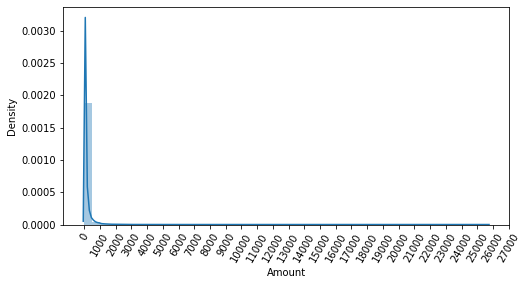

In [78]:
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

거의 1000불 이하. 꼬리가 긴 형태의 분포 곡선
-> Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정

In [97]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [98]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬:
 [[85281    14]
 [   58    90]]

정확도: 0.9992
정밀도: 0.8654
재현율: 0.6081
F1: 0.7143
AUC: 0.8040
### LightGBM 예측 성능 ###
오차행렬:
 [[85216    79]
 [   57    91]]

정확도: 0.9984
정밀도: 0.5353
재현율: 0.6149
F1: 0.5723
AUC: 0.8070


성능이 크게 개선되지는 않았음 


`로그 변환` 수행 
- 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법
- 원래 값을 log 값으로 변환해, 상대적으로 작은 값으로 변호나하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해줌

In [99]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [100]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬:
 [[85283    12]
 [   59    89]]

정확도: 0.9992
정밀도: 0.8812
재현율: 0.6014
F1: 0.7149
AUC: 0.8006
### LightGBM 예측 성능 ###
오차행렬:
 [[85182   113]
 [   79    69]]

정확도: 0.9978
정밀도: 0.3791
재현율: 0.4662
F1: 0.4182
AUC: 0.7324


- (음 저는 떨어지네요?...)

### 이상치 데이터 제거 후 모델 학습/예측/평가

- Outlier(이상치 데이터)
    - IQR : 사분위 값의 편차를 이용하는 기법으로 박스 플롯으로 시각화할 수 있음
    - 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최대값과 최소값을 결정한 뒤 이에 초과/미달하는 데이터를 이상치로 간주
    - Q3 + IQR*1.5 => 최대값.
    - Q1 - IQR*1.5 => 최소값

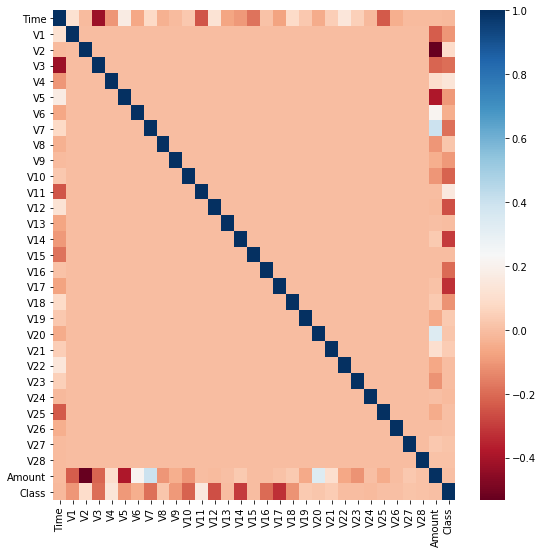

In [101]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

- 양의 상관 관계가 높을수록 파란색, 음의 상관관계가 높을수록 빨간 색

- Class 피처와 음의 상관관계가 가장 높은 피처는 V14, V17
    - V14에 대한 이상치만 제거해보자.

In [104]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    q_25 = np.percentile(fraud.values, 25)
    q_75 = np.percentile(fraud.values, 75)
    
    iqr = q_75 - q_25
    iqr_weight = iqr *weight
    lowest_val = q_25 - iqr_weight
    highest_val = q_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [105]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 인덱스:', outlier_index)

이상치 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


이상치 인덱스를 삭제

In [106]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [107]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬:
 [[85281    14]
 [   48    98]]

정확도: 0.9993
정밀도: 0.8750
재현율: 0.6712
F1: 0.7597
AUC: 0.8355
### LightGBM 예측 성능 ###
오차행렬:
 [[85268    27]
 [   36   110]]

정확도: 0.9993
정밀도: 0.8029
재현율: 0.7534
F1: 0.7774
AUC: 0.8766


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [110]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts()) # 분포가 동일해짐

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 1    199020
0    199020
Name: Class, dtype: int64


In [111]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차행렬:
 [[82937  2358]
 [   11   135]]

정확도: 0.9723
정밀도: 0.0542
재현율: 0.9247
F1: 0.1023
AUC: 0.9485


- 재현율이 크게 증가했지만, 정밀도가 급격하게 저하됨
- 이정도로 낮은 정밀도는 현실에 적용시킬 수 없음
- 오버샘플링으로 인해 실제 데이터 세트에서 예측을 지나치게 Class=1 로 적용해 정밀도가 급격하게 떨어지게 된 것

In [112]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

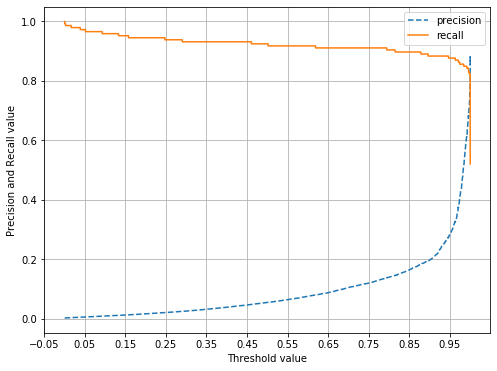

In [113]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- 임계값 0.99이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가, 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아짐
- 임계값의 민감도가 심해 좋은 성능을 얻을 수 없으므로, LightGBM에 SMOTE를 적용해보자

In [114]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차행렬:
 [[85283    12]
 [   22   124]]

정확도: 0.9996
정밀도: 0.9118
재현율: 0.8493
F1: 0.8794
AUC: 0.9246


- SMOTE에서는 재현율은 높아지나 정밀도는 낮아지는 것이 일반적

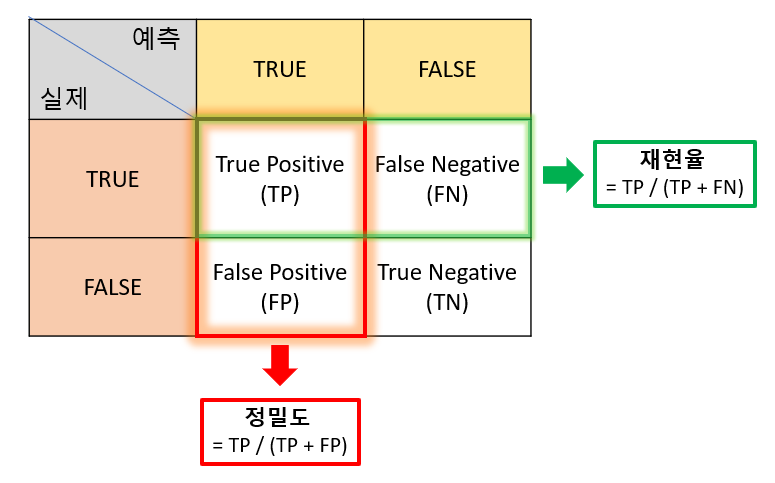

## 스태킹 앙상블
![](https://blog.kakaocdn.net/dn/cM3MVi/btqF3GahzmF/XJjnJf0pUiUkJs0nSEc4y1/img.png)

- 스태킹은 여러 알고리즘을 결합해 결과를 도출한다는 점에서 배깅과 부스팅과 유사
- But, **개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행함.**
    - 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고, 테스트 데이터 기반으로 다시 최종 예측을 수행
    - 메타 모델 : 개별 모델의 예측된 데이터 셋을 기반으로 다시 학습하고 예측하는 방식


필요
1. 개별적인 기반 모델
2. 이 개별 기반 모델의 에측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

요약 -> 여러 개의 모델에 대한 예측값을 쌓아서 메타 모델을 만들어 다시 예측을 수행하는 것

### 기본 스태킹 모델

In [4]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [5]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression(C=10)

In [6]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [7]:
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)


In [8]:
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [9]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

(4, 114)


In [10]:
# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피쳐로 만듦

pred = np.transpose(pred)
print(pred.shape)

(114, 4)


In [11]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


### CV 세트 기반의 스태킹

![image](https://user-images.githubusercontent.com/48315997/104113664-17aa1680-533f-11eb-8310-e64cdf6b549a.png)


- 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때, 교차 검증 기반으로 예측된 결과 데이터 세트를 이용함.
    - 앞 예제에서 마지막에 메타 모델을 학습시킬 때, 학습 데이터가 아닌 테스트용 레이블 세트를 기반으로 학습했기 때문에 과적합 문제가 생길 수 있음 (동일 데이터로 계속 훈련하니까)
- 이를 개선하기 위해 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 태스트용 스태킹 데이터를 생성한 뒤, 이를 기반으로 메타 모델이 학습과 예측을 수행


1. 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성
2. 개별 모델들이 생성한 학습용 데이터를 모두 **스태킹** 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성
- 최종 테스트용 데이터 세트도 마찬가지
3. 메타 모델은 최종적으로 생성된 학습 데이터 셋과 원본 학습 데이터의 레이블 값을 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 셋을 예측하고, 원본 테스트 셋을 기반으로 평가함.

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [16]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

/Users/yeonsookim/opt/anaconda3/envs/PyTorch_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/yeonsookim/opt/anaconda3/envs/PyTorch_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


/Users/yeonsookim/opt/anaconda3/envs/PyTorch_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/yeonsookim/opt/anaconda3/envs/PyTorch_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [17]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
     '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [18]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


## 정리

- 현대 앙상블 기법은 부스팅이 주류이다
    - 부스팅은 학습기들이 순차적으로 학습을 진행하면서, 예측이 틀린 데이터에 대해 가중치를 부여하는 방식
    - `XGBoost`, `LightGBM`
- 스태킹 모델
    - 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 셋을 생성하는 방식
    - 핵심 : 메타 모델이 사용할 학습 데이터 셋과 예측 데이터 셋을 개별 모델의 예측 값들을 스태킹 형태로 결합해 생성